In [55]:
import tensorflow as tf

train_ds = tf.keras.utils.image_dataset_from_directory(
    "/kaggle/input/cifar10-pngs-in-folders/cifar10/train",
    validation_split=0.2,       # 20% of training for validation
    subset="training",
    seed=42,                    # ensures same split each run
    image_size=(32, 32),
    batch_size=64,
    label_mode="categorical"
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    "/kaggle/input/cifar10-pngs-in-folders/cifar10/train",
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(32, 32),
    batch_size=64,
    label_mode="categorical"
)


Found 50000 files belonging to 10 classes.
Using 40000 files for training.
Found 50000 files belonging to 10 classes.
Using 10000 files for validation.


In [56]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    "/kaggle/input/cifar10-pngs-in-folders/cifar10/test",
    image_size=(32, 32),
    batch_size=64,
    label_mode="categorical"
)


Found 10000 files belonging to 10 classes.


In [57]:
class_names = train_ds.class_names
print(class_names)


['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [58]:
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

## visualize the training data

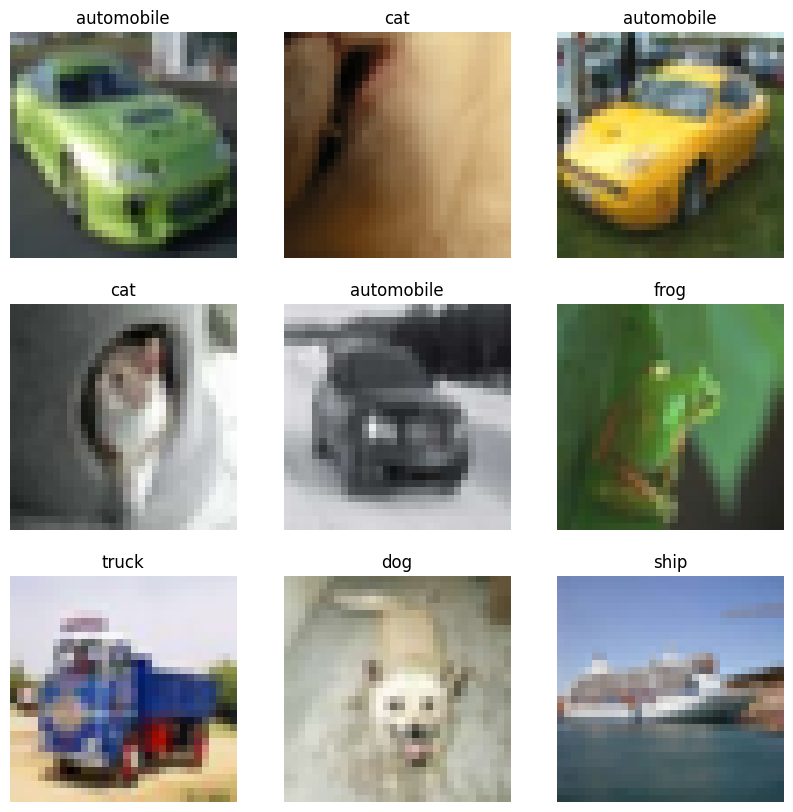

In [59]:

import matplotlib.pyplot as plt

# Example: visualize some training images
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):  # take one batch
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        
        img = images[i].numpy()
        
        # If already in [0,1], keep it. If in [0,255], normalize
        if img.max() > 1.0:
            img = img.astype("uint8")   # values 0–255
        else:
            img = np.clip(img, 0, 1)    # keep in 0–1 range
        
        plt.imshow(img)
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")


In [60]:
print("Train batches:", tf.data.experimental.cardinality(train_ds).numpy())
print("Validatation batches:", tf.data.experimental.cardinality(val_ds).numpy())
print("Test batches:", tf.data.experimental.cardinality(test_ds).numpy())

class_names = train_ds.class_names
print("Classes:", class_names)


Train batches: 625
Validatation batches: 157
Test batches: 157
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [61]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds   = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds  = test_ds.map(lambda x, y: (normalization_layer(x), y))


In [62]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])


## model architure

In [63]:
""""model = tf.keras.Sequential([
    data_augmentation,#It acts like a preprocessing layer that sits at the start of your CNN.
    tf.keras.layers.Conv2D(512, (3,3), activation='relu', input_shape=(32,32,3)),
    tf.keras.layers.Conv2D(256,(3,3),activation='relu'),
    tf.keras.layers.MaxPool2D((2,2)),
    tf.keras.layers.Conv2D(128,(3,3),activation='relu'),
    tf.keras.layers.MaxPool2D((2,2)),
    tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
    tf.keras.layers.MaxPool2D((2,2)),
    tf.keras.layers.Conv2D(32, (3,3), padding="same"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dense(10,activation='softmax')                     
])"""

import tensorflow as tf
from tensorflow.keras import layers, models

# Data augmentation block
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

model = models.Sequential([
    data_augmentation,  # 👈 augmentation only active during training

    layers.Conv2D(32, (3,3), padding="same", activation="relu", input_shape=(32,32,3)),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3,3), padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.25),

    layers.Conv2D(64, (3,3), padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3,3), padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.25),

    layers.Conv2D(128, (3,3), padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3,3), padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.4),

    layers.Flatten(),
    layers.Dense(256, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(10, activation="softmax")  # CIFAR-10 has 10 classes
])

model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [64]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

## training

In [65]:
"""early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    restore_best_weights=True
)"""
history=model.fit(train_ds,validation_data=val_ds,epochs=50)

Epoch 1/50


E0000 00:00:1758643418.757323      36 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_7_1/dropout_8_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


625/625 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - accuracy: 0.3089 - loss: 2.2193 - val_accuracy: 0.4866 - val_loss: 1.4520
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - accuracy: 0.4809 - loss: 1.4506 - val_accuracy: 0.5441 - val_loss: 1.3033
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.5504 - loss: 1.2638 - val_accuracy: 0.5702 - val_loss: 1.2141
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.5885 - loss: 1.1530 - val_accuracy: 0.5675 - val_loss: 1.2421
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - accuracy: 0.6169 - loss: 1.0790 - val_accuracy: 0.6609 - val_loss: 0.9481
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - accuracy: 0.6384 - loss: 1.0240 - val_accuracy: 0.6337 - val_loss: 1.0414
Epoch 7/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - accuracy: 0.6629 - loss: 0.9645 - val_accuracy: 0.7029 - val_loss: 0.8600
Epoch 8/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.6742 - loss: 0.9332 - val_accurac

## model evaluation 

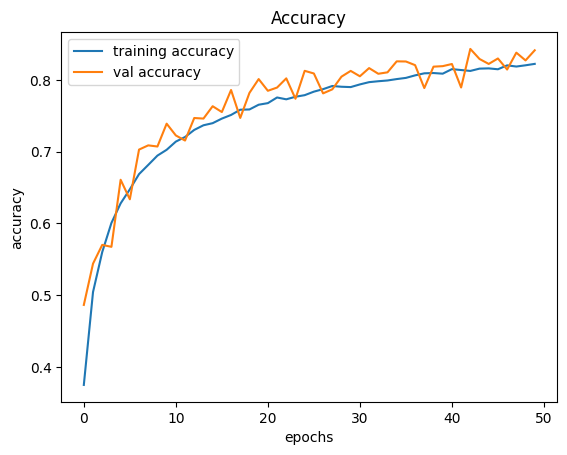

In [ ]:
import matplotlib.pyplot as plt
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

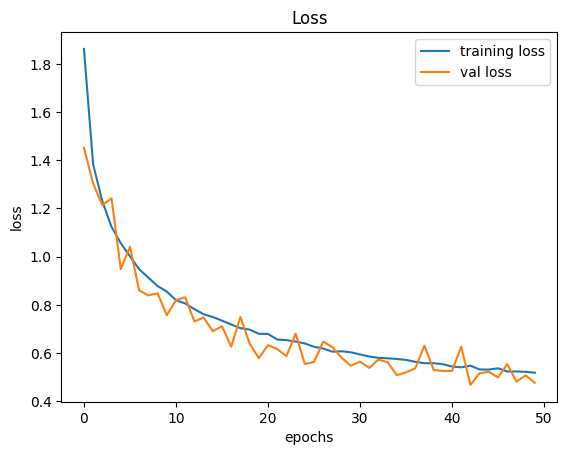

In [67]:
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [68]:
# Evaluate on the test dataset
test_loss, test_acc = model.evaluate(test_ds, verbose=2)

print("Test accuracy:", test_acc)
print("Test loss:", test_loss)


157/157 - 5s - 30ms/step - accuracy: 0.8360 - loss: 0.4826
Test accuracy: 0.8360000252723694
Test loss: 0.48263636231422424


## test the model on test data 

In [69]:
def predict_from_dataset(model, dataset, class_names, num_samples=5):
    import matplotlib.pyplot as plt
    import numpy as np
    
    plt.figure(figsize=(12, 6))
    for images, labels in dataset.take(1):  # Take 1 batch
        for i in range(num_samples):
            img = images[i].numpy() / 255.0 if np.max(images[i].numpy()) > 1 else images[i].numpy()
            true_label = np.argmax(labels[i].numpy())
            
            # Predict
            img_input = np.expand_dims(img, axis=0)
            pred = model.predict(img_input, verbose=0)
            class_id = np.argmax(pred)
            
            # Show image
            plt.subplot(1, num_samples, i+1)
            plt.imshow(img)
            plt.title(f"Pred: {class_names[class_id]}\nTrue: {class_names[true_label]}")
            plt.axis("off")
    plt.show()


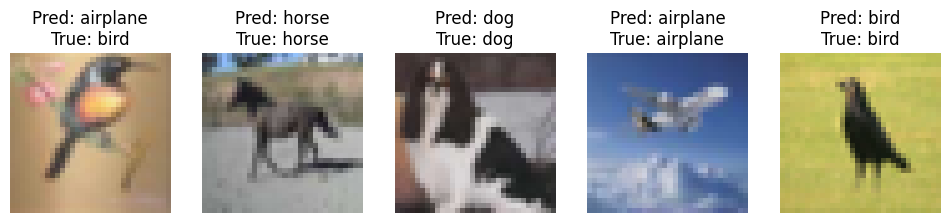

In [70]:


predict_from_dataset(model, test_ds, class_names, num_samples=5)


## test on external data

In [71]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def predict_cifar10_image(img_path, model, class_names):
 
    # Load and preprocess image
    img = cv2.imread(img_path)                        # Read image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)        # Convert BGR → RGB
    img_resized = cv2.resize(img, (32, 32)) / 255.0   # Resize & normalize
    img_input = np.expand_dims(img_resized, axis=0)   # Add batch dimension
    
    # Prediction
    pred = model.predict(img_input, verbose=0)
    class_id = np.argmax(pred)
    class_name = class_names[class_id]
    
    # Show image with prediction
    plt.imshow(img)
    plt.title(f"Prediction: {class_name}")
    plt.axis("off")
    plt.show()
    
    print(f"Predicted Class ID: {class_id}")
    print(f"Predicted Class Name: {class_name}")
    return class_id, class_name


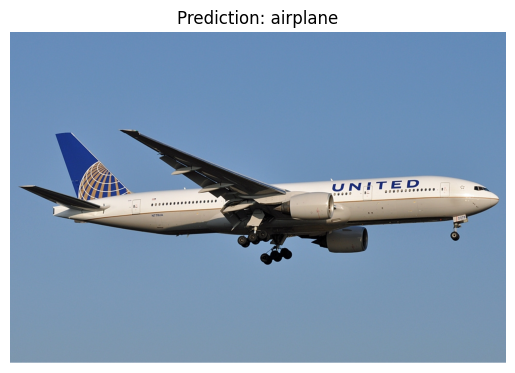

Predicted Class ID: 0
Predicted Class Name: airplane


(0, 'airplane')

In [72]:
predict_cifar10_image("/kaggle/input/airplane/airplane.jpg",model,class_names)

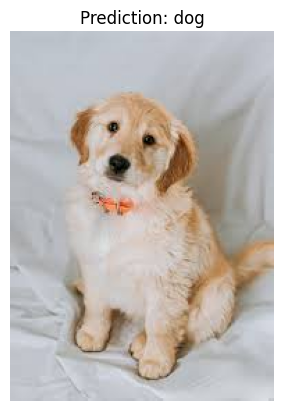

Predicted Class ID: 5
Predicted Class Name: dog


(5, 'dog')

In [73]:
predict_cifar10_image("/kaggle/input/dog-img/dog.jpg",model,class_names)

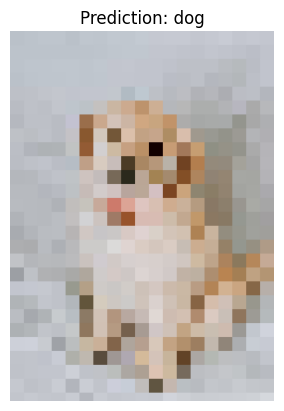

Predicted Class ID: 5
Predicted Class Name: dog


(5, 'dog')

In [74]:
predict_cifar10_image("/kaggle/input/dog-noisy/dog_noisy.png",model,class_names)

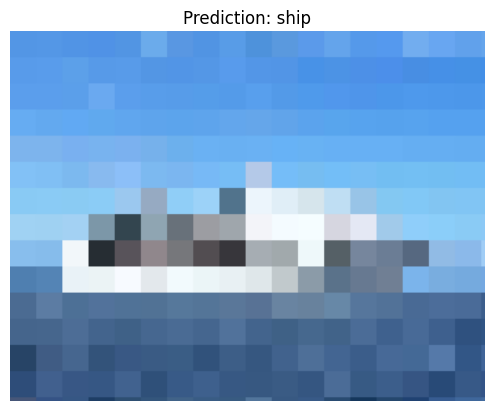

Predicted Class ID: 8
Predicted Class Name: ship


(8, 'ship')

In [75]:
predict_cifar10_image("/kaggle/input/niosy-ship/noisy_ship.png",model,class_names)

## confusion matrix

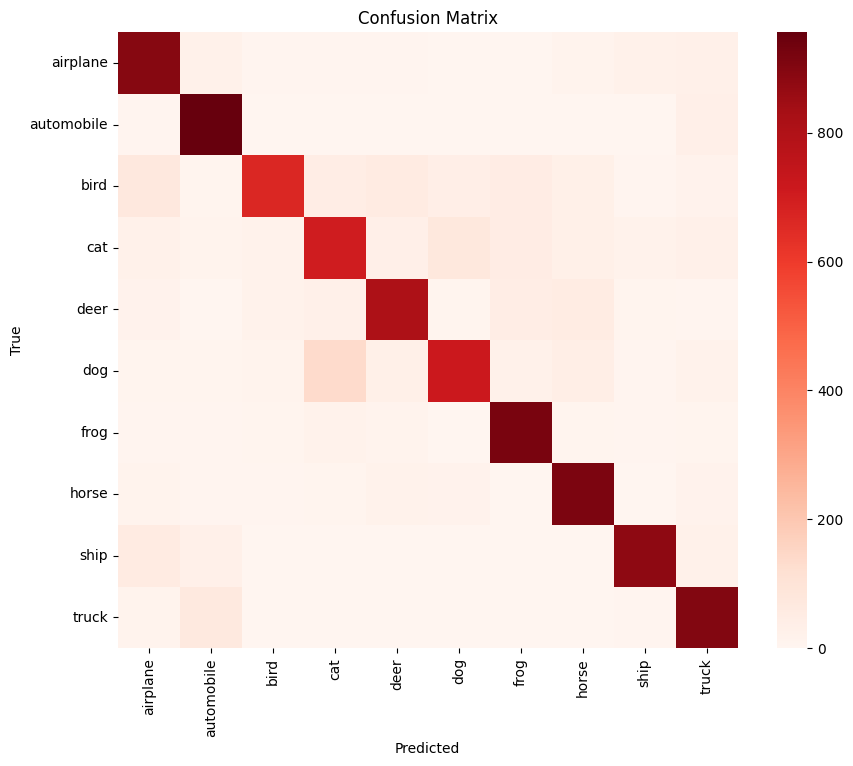

In [76]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, dataset, class_names):
    y_true = []
    y_pred = []

    for images, labels in dataset:
        preds = model.predict(images, verbose=0)
        y_true.extend(np.argmax(labels.numpy(), axis=1))
        y_pred.extend(np.argmax(preds, axis=1))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, cmap="Reds",
                xticklabels=class_names,
                yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

plot_confusion_matrix(model, test_ds, class_names)


In [77]:
model.save("cifar10_cnn.h5")
